../images/car.jpg 	1.0
../images/bb.jpg 	-1.0


(<matplotlib.axes._subplots.AxesSubplot at 0x6c758b0>,
 <matplotlib.text.Text at 0x729c970>)

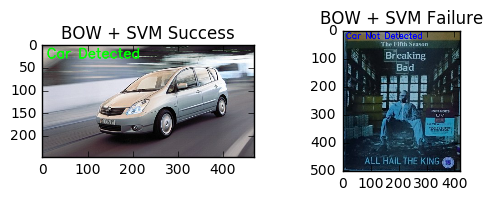

In [2]:
# %load detect_hog_svm.py
import cv2
import numpy as np
from os.path import join
from matplotlib import pyplot as plot
%matplotlib inline

datapath = "./CarData/TrainImages/"
def path(cls,i):
  return "%s/%s%d.pgm"  % (datapath,cls,i+1)

pos, neg = "pos-", "neg-"

detect = cv2.xfeatures2d.SIFT_create()
extract = cv2.xfeatures2d.SIFT_create()

flann_params = dict(algorithm = 1, trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})

bow_kmeans_trainer = cv2.BOWKMeansTrainer(40)
extract_bow = cv2.BOWImgDescriptorExtractor(extract, matcher)

def extract_sift(fn):
  im = cv2.imread(fn,0)
  return extract.compute(im, detect.detect(im))[1]
  
for i in range(8):
  bow_kmeans_trainer.add(extract_sift(path(pos,i)))
  bow_kmeans_trainer.add(extract_sift(path(neg,i)))
  
voc = bow_kmeans_trainer.cluster()
extract_bow.setVocabulary( voc )

def bow_features(fn):
  im = cv2.imread(fn,0)
  return extract_bow.compute(im, detect.detect(im))

traindata, trainlabels = [],[]
for i in range(20): 
  traindata.extend(bow_features(path(pos, i))); trainlabels.append(1)
  traindata.extend(bow_features(path(neg, i))); trainlabels.append(-1)

svm = cv2.ml.SVM_create()
svm.train(np.array(traindata), cv2.ml.ROW_SAMPLE, np.array(trainlabels))

def predict(fn):
  f = bow_features(fn);  
  p = svm.predict(f)
  print fn, "\t", p[1][0][0]
  return p
  
car, notcar = "../images/car.jpg", "../images/bb.jpg"
car_img = cv2.imread(car)
notcar_img = cv2.imread(notcar)
car_predict = predict(car)
not_car_predict = predict(notcar)

font = cv2.FONT_HERSHEY_SIMPLEX

if (car_predict[1][0][0] == 1.0):
  cv2.putText(car_img,'Car Detected',(10,30), font, 1,(0,255,0),2,cv2.LINE_AA)

if (not_car_predict[1][0][0] == -1.0):
  cv2.putText(notcar_img,'Car Not Detected',(10,30), font, 1,(0,0, 255),2,cv2.LINE_AA)

plot.subplot(221), plot.imshow(car_img), plot.title('BOW + SVM Success')
plot.subplot(222), plot.imshow(notcar_img), plot.title('BOW + SVM Failure')

